## Import Libraries

In [1]:
import os
import gc

# Configure JAX backend for Keras (better memory management and performance)
os.environ["KERAS_BACKEND"] = "jax"
# Disable strict convolution algorithm picker to avoid potential GPU issues
os.environ["XLA_FLAGS"] = "--xla_gpu_strict_conv_algorithm_picker=false"

import keras_nlp
import keras
import tensorflow as tf
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.metrics import Precision, Recall

2025-06-02 06:00:41.643550: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748844041.841808      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748844041.903155      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### Library Version

In [2]:
# Version Check
print("TensorFlow:", tf.__version__)
print("Keras:", keras.__version__)
print("KerasNLP:", keras_nlp.__version__)

TensorFlow: 2.18.0
Keras: 3.8.0
KerasNLP: 0.18.1


## Configuration

In [3]:
# Centralized configuration makes hyperparameter tuning easier

class CFG:
    seed = 42  # For reproducibility across runs
    
    # Model Selection: DeBERTa-v3 Extra Small for efficiency
    # Trade-off between model capacity and computational requirements
    preset = "deberta_v3_extra_small_en"  
    
    # Sequence length: 512 tokens should capture most prompt+response pairs
    max_seq_length = 512
    
    # Training parameters optimized for memory constraints
    epochs = 3  # Quick training for competition timeline
    batch_size = 8  # Reduced to prevent OOM errors
    gradient_accumulation_steps = 2  # Maintain effective batch size of 16
    
    scheduler = 'cosine'  # Cosine annealing for better convergence
    
    # Label mappings for the three-class classification problem
    label2name = {0: 'winner_model_a', 1: 'winner_model_b', 2: 'winner_tie'}
    name2label = {v:k for k, v in label2name.items()}
    class_labels = list(label2name.keys())
    class_names = list(label2name.values())

In [4]:
# Critical for preventing OOM errors during training

# Clear any existing Keras/TF sessions
keras.backend.clear_session()
tf.keras.backend.clear_session()
gc.collect()  # Force garbage collection

0

In [5]:
strategy = tf.distribute.get_strategy()
print("Running on CPU/GPU")

Running on CPU/GPU


## Reproducibility

In [6]:
# Reproducibility Setup
keras.utils.set_random_seed(CFG.seed)
# Ensures consistent results across runs for fair comparison

## Mixed Precision

In [7]:
# Use mixed precision to reduce memory usage and speed up training
# FP16 for forward pass, FP32 for loss computation
keras.mixed_precision.set_global_policy("mixed_float16")

## Dataset Path

In [8]:
# Data Path Configuration
BASE_PATH = '/kaggle/input/llm-classification-finetuning'

In [9]:
# Data Loading & Preprocessing Function
def load_data(path):
    """
    Load and preprocess the competition data.
    
    The raw data has prompts and responses stored as string representations
    of lists, so we need to evaluate them to extract the actual content.
    """
    df = pd.read_csv(path)
    
    # Extract first prompt from list format (some entries have multiple prompts)
    df["prompt"] = df.prompt.map(lambda x: eval(x)[0])
    
    # Handle null values in responses and extract first response
    # Replace 'null' string with empty string to avoid eval errors
    df["response_a"] = df.response_a.map(lambda x: eval(x.replace("null","''"))[0])
    df["response_b"] = df.response_b.map(lambda x: eval(x.replace("null","''"))[0])
    
    return df

In [10]:
# Load Training and Test Data
df = load_data(f'{BASE_PATH}/train.csv')
test_df = load_data(f'{BASE_PATH}/test.csv')

print(f"Training data shape: {df.shape}")
print(f"Test data shape: {test_df.shape}")

Training data shape: (57477, 9)
Test data shape: (3, 4)


In [11]:
# Convert one-hot encoded winners to single class labels

# Find which model won (or if it was a tie) for each row
df["class_name"] = df[["winner_model_a", "winner_model_b", "winner_tie"]].idxmax(axis=1)
# Convert to numeric labels for model training
df["class_label"] = df.class_name.map(CFG.name2label)

print("Class distribution:")
print(df.class_name.value_counts())

Class distribution:
class_name
winner_model_a    20064
winner_model_b    19652
winner_tie        17761
Name: count, dtype: int64


### Data Augmentation: Response Swapping

In [12]:
# Critical technique to reduce position bias in the model

def swap_responses(row):
    """
    Randomly swap response_a and response_b positions.
    
    This data augmentation technique helps the model avoid learning
    position bias (always preferring the first or second response).
    When we swap responses, we also need to swap the corresponding labels.
    """
    if np.random.rand() > 0.5:  # 50% chance to swap
        # Swap the actual responses
        row["response_a"], row["response_b"] = row["response_b"], row["response_a"]
        
        # Update labels accordingly
        if row["class_name"] == "winner_model_a":
            row["class_name"] = "winner_model_b"
        elif row["class_name"] == "winner_model_b":
            row["class_name"] = "winner_model_a"
        # Ties remain ties after swapping
    
    # Update numeric label
    row["class_label"] = CFG.name2label[row["class_name"]]
    return row

## Preprocessing

In [13]:
# Initialize DeBERTa-v3 preprocessor for tokenization

preprocessor = keras_nlp.models.DebertaV3Preprocessor.from_preset(
    preset=CFG.preset,
    sequence_length=CFG.max_seq_length,
)

print(f"Preprocessor vocabulary size: {preprocessor.tokenizer.vocabulary_size()}")

I0000 00:00:1748844060.660069      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1748844060.660768      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Preprocessor vocabulary size: 128001


In [14]:
# Preprocessing Function
def preprocess_fn(text, label=None):
    """
    Apply tokenization and preprocessing to text inputs.
    
    The preprocessor handles:
    - Tokenization using DeBERTa's vocabulary
    - Adding special tokens ([CLS], [SEP])
    - Padding/truncating to max_seq_length
    - Creating attention masks
    """
    text = preprocessor(text)
    return (text, label) if label is not None else text

### Contextualize Response with Prompt

In [15]:
# Format prompt and responses into comparable text pairs

def make_pairs(row):
    """
    Create formatted text pairs for model input.
    
    Each row will have two options:
    1. "Prompt: X\n\nResponse: A"  
    2. "Prompt: X\n\nResponse: B"
    
    The model will learn to compare these formatted strings.
    """
    row["encode_fail"] = False
    
    # Handle potential encoding issues gracefully
    try:
        prompt = row.prompt.encode("utf-8").decode("utf-8")
    except:
        prompt = ""
        row["encode_fail"] = True

    try:
        response_a = row.response_a.encode("utf-8").decode("utf-8")
    except:
        response_a = ""
        row["encode_fail"] = True

    try:
        response_b = row.response_b.encode("utf-8").decode("utf-8")
    except:
        response_b = ""
        row["encode_fail"] = True
    
    # Create structured format for model input
    row['options'] = [
        f"Prompt: {prompt}\n\nResponse: {response_a}",
        f"Prompt: {prompt}\n\nResponse: {response_b}"
    ]
    return row

In [16]:
# Apply Text Pair Creation
df = df.apply(make_pairs, axis=1)
test_df = test_df.apply(make_pairs, axis=1)

# Check for encoding failures
encoding_failures = df['encode_fail'].sum()
print(f"Encoding failures in training data: {encoding_failures}")

Encoding failures in training data: 592


# DataLoader

In [17]:
# Dataset Building Function
def build_dataset(texts, labels=None, batch_size=32, cache=True, shuffle=1024):
    """
    Build optimized TensorFlow datasets for training/inference.
    
    Optimizations included:
    - Caching for repeated epoch access
    - Parallel preprocessing
    - Prefetching for pipeline efficiency
    - Optional shuffling for training
    """
    AUTO = tf.data.AUTOTUNE
    
    # Create tensor slices - include labels for training, exclude for test
    if labels is None:
        slices = (texts,)
    else:
        # Convert labels to one-hot encoding for categorical crossentropy
        slices = (texts, keras.utils.to_categorical(labels, num_classes=3))
    
    ds = tf.data.Dataset.from_tensor_slices(slices)
    
    # Cache dataset in memory for faster epoch iterations
    ds = ds.cache() if cache else ds
    
    # Apply preprocessing in parallel
    ds = ds.map(preprocess_fn, num_parallel_calls=AUTO)
    
    # Configure dataset options
    opt = tf.data.Options()
    if shuffle: 
        ds = ds.shuffle(shuffle, seed=CFG.seed)
        opt.experimental_deterministic = False  # Allow non-deterministic for speed
    ds = ds.with_options(opt)
    
    # Batch and prefetch for efficiency
    ds = ds.batch(batch_size, drop_remainder=False)
    ds = ds.prefetch(AUTO)  # Prefetch next batch while training current
    
    return ds

## LR Schedule

In [18]:
# Learning Rate Schedule Function
def get_lr_callback(batch_size=8, mode='cosine', epochs=10, plot=False):
    """
    Create sophisticated learning rate schedule with warmup and decay.
    
    Learning rate strategy:
    1. Warmup: Gradually increase LR to prevent early instability
    2. Sustain: Brief period at peak LR (optional)
    3. Decay: Cosine/linear decay to fine-tune weights
    
    The LR is scaled based on effective batch size following the
    linear scaling rule from large batch training literature.
    """
    # Calculate effective batch size with gradient accumulation
    effective_batch_size = batch_size * CFG.gradient_accumulation_steps
    
    # Scale learning rate with batch size (linear scaling rule)
    # Larger batches need higher learning rates to maintain training dynamics
    lr_start = 1.0e-6  # Conservative starting point
    lr_max = 1.0e-6 * (effective_batch_size / 8)  # Scale up for larger batches
    lr_min = 1.0e-7  # Very low minimum to continue fine-tuning
    
    # Schedule phases
    lr_ramp_ep = 2  # Warmup epochs - critical for transformer stability
    lr_sus_ep = 0   # Sustain epochs at peak LR
    
    def lrfn(epoch):
        # Phase 1: Warmup - linear increase to prevent early training instability
        if epoch < lr_ramp_ep:
            lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
        
        # Phase 2: Sustain - maintain peak LR briefly (if lr_sus_ep > 0)
        elif epoch < lr_ramp_ep + lr_sus_ep:
            lr = lr_max
            
        # Phase 3: Decay - reduce LR for fine-tuning
        else:
            decay_total_epochs = max(1, epochs - lr_ramp_ep - lr_sus_ep)
            decay_epoch = epoch - lr_ramp_ep - lr_sus_ep
            decay_ratio = decay_epoch / decay_total_epochs
            
            if mode == 'cosine':
                # Cosine annealing - smooth decay that works well with transformers
                import math
                lr = lr_min + 0.5 * (lr_max - lr_min) * (1 + math.cos(math.pi * decay_ratio))
            elif mode == 'linear':
                # Linear decay - simpler alternative
                lr = lr_max - (lr_max - lr_min) * decay_ratio
            else:
                # Constant LR fallback
                lr = lr_max
                
        return lr

    # Visualize learning rate schedule for debugging
    if plot:
        plt.figure(figsize=(10, 5))
        epochs_range = np.arange(epochs)
        lr_values = [lrfn(epoch) for epoch in epochs_range]
        plt.plot(epochs_range, lr_values)
        plt.title(f'Learning Rate Schedule ({mode})')
        plt.xlabel('Epoch')
        plt.ylabel('Learning Rate')
        plt.grid(True)
        plt.yscale('log')  # Log scale better shows LR changes
        plt.show()
        
        print(f"LR Range: {min(lr_values):.2e} to {max(lr_values):.2e}")

    return keras.callbacks.LearningRateScheduler(lrfn, verbose=False)

## Modeling

In [19]:
# Model Architecture
def build_model():
    """
    Build DeBERTa-v3 based preference classification model.
    
    Architecture:
    1. Shared DeBERTa backbone processes both response options
    2. Concatenate embeddings from both responses  
    3. Global average pooling to get fixed-size representation
    4. Dropout for regularization
    5. Dense layer with softmax for 3-class prediction
    
    This siamese-like architecture allows the model to compare
    responses while sharing weights efficiently.
    """
    # Clear memory before building
    gc.collect()
    
    # Define inputs - we'll process pairs of sequences
    # Shape: (batch_size, 2, sequence_length) for token_ids and padding_mask
    inputs = {
        "token_ids": keras.Input(shape=(2, None), dtype=tf.int32, name="token_ids"),
        "padding_mask": keras.Input(shape=(2, None), dtype=tf.int32, name="padding_mask"),
    }
    
    # Load pre-trained DeBERTa backbone
    backbone = keras_nlp.models.DebertaV3Backbone.from_preset(CFG.preset)
    
    with strategy.scope():  # Ensure model is built in distribution strategy scope
        # Process each response option through shared backbone
        # Extract first option (response A)
        response_a = {k: v[:, 0, :] for k, v in inputs.items()}
        embed_a = backbone(response_a)  # Shape: (batch_size, seq_len, hidden_dim)
        
        # Extract second option (response B)  
        response_b = {k: v[:, 1, :] for k, v in inputs.items()}
        embed_b = backbone(response_b)  # Shape: (batch_size, seq_len, hidden_dim)
        
        # Combine embeddings from both responses
        # This allows the model to directly compare the representations
        embeds = keras.layers.Concatenate(axis=-1)([embed_a, embed_b])
        
        # Global average pooling to get fixed-size representation
        embeds = keras.layers.GlobalAveragePooling1D()(embeds)
        
        # Regularization to prevent overfitting
        embeds = keras.layers.Dropout(0.3)(embeds)
        
        # Final classification layer
        outputs = keras.layers.Dense(
            3,  # Three classes: model_a wins, model_b wins, tie
            activation="softmax",  # Probability distribution over classes
            kernel_regularizer=keras.regularizers.l2(1e-4)  # L2 regularization
        )(embeds)
        
        # Create and compile model
        model = keras.Model(inputs, outputs)
        model.compile(
            optimizer=keras.optimizers.Adam(5e-6),  # Conservative learning rate
            loss=keras.losses.CategoricalCrossentropy(
                label_smoothing=0.02  # Slight label smoothing for robustness
            ),
            metrics=[keras.metrics.CategoricalAccuracy(name="accuracy")]
        )
    
    print(f"Model built with {model.count_params():,} parameters")
    return model

In [20]:
# Free up memory before splitting
gc.collect()

# Stratified split to maintain class balance across train/validation
train_df, valid_df = train_test_split(
    df, 
    test_size=0.2, 
    stratify=df["class_label"],  # Ensure balanced class distribution
    random_state=CFG.seed
)

print("Class distribution in training set:")
print(train_df.class_name.value_counts(normalize=True))

print("\nClass distribution in validation set:")  
print(valid_df.class_name.value_counts(normalize=True))

# Apply response swapping augmentation to training data only
train_df = train_df.apply(swap_responses, axis=1)

print(f"\nTraining samples: {len(train_df)}")
print(f"Validation samples: {len(valid_df)}")

Class distribution in training set:
class_name
winner_model_a    0.349079
winner_model_b    0.341902
winner_tie        0.309019
Name: proportion, dtype: float64

Class distribution in validation set:
class_name
winner_model_a    0.349078
winner_model_b    0.341945
winner_tie        0.308977
Name: proportion, dtype: float64

Training samples: 45981
Validation samples: 11496


In [21]:
# Build TensorFlow datasets with optimized pipeline

print("Building training dataset...")
train_ds = build_dataset(
    train_df.options.tolist(), 
    train_df.class_label.tolist(), 
    batch_size=CFG.batch_size
)

print("Building validation dataset...")
valid_ds = build_dataset(
    valid_df.options.tolist(), 
    valid_df.class_label.tolist(), 
    batch_size=CFG.batch_size
)

# Free up memory from dataframes no longer needed
del train_df, valid_df
gc.collect()

print("Datasets created successfully!")

Building training dataset...
Building validation dataset...
Datasets created successfully!


Building model...


INFO:2025-06-02 06:01:56,206:jax._src.xla_bridge:924: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:2025-06-02 06:01:56,218:jax._src.xla_bridge:924: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory


Model built with 70,684,419 parameters


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)           ┃ Output Shape         ┃      Param # ┃ Connected to        ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ padding_mask           │ (None, 2, None)      │            0 │ -                   │    -    │
│ (InputLayer)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ token_ids (InputLayer) │ (None, 2, None)      │            0 │ -                   │    -    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ get_item_1 (GetItem)   │ (None, None)         │            0 │ padding_mask[0][0]  │    -    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ get_item (GetItem)     │ (None, None)         │            0 │ token_ids[0][0]     │    -    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ get_item_3 (GetItem)   │ (None, None)         │            0 │ padding_mask[0][0]  │    -    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ get_item_2 (GetItem)   │ (None, None)         │            0 │ token_ids[0][0]     │    -    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ deberta_v3_backbone    │ (None, None, 384)    │   70,682,112 │ get_item_1[0][0],   │    Y    │
│ (DebertaV3Backbone)    │                      │              │ get_item[0][0],     │         │
│                        │                      │              │ get_item_3[0][0],   │         │
│                        │                      │              │ get_item_2[0][0]    │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ concatenate            │ (None, None, 768)    │            0 │ deberta_v3_backbon… │    -    │
│ (Concatenate)          │                      │              │ deberta_v3_backbon… │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ global_average_poolin… │ (None, 768)          │            0 │ concatenate[0][0]   │    -    │
│ (GlobalAveragePooling… │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ dropout_12 (Dropout)   │ (None, 768)          │            0 │ global_average_poo… │    -    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ dense (Dense)          │ (None, 3)            │        2,307 │ dropout_12[0][0]    │    Y    │
└────────────────────────┴──────────────────────┴──────────────┴─────────────────────┴─────────┘

 Total params: 70,684,419 (269.64 MB)

 Trainable params: 70,684,419 (269.64 MB)

 Non-trainable params: 0 (0.00 B)

Setting up training callbacks...


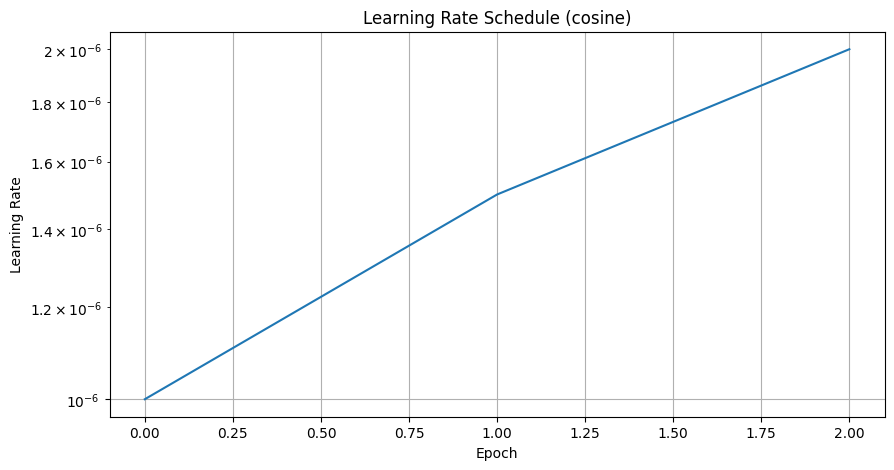

LR Range: 1.00e-06 to 2.00e-06


In [22]:
# Model Training Setup
print("Building model...")
model = build_model()

# Display model architecture
model.summary(show_trainable=True)

# Setup callbacks
print("Setting up training callbacks...")

# Learning rate scheduler with visualization
lr_cb = get_lr_callback(
    CFG.batch_size, 
    mode=CFG.scheduler, 
    epochs=CFG.epochs, 
    plot=True
)

# Model checkpointing to save best weights
ckpt_cb = keras.callbacks.ModelCheckpoint(
    'best_model.weights.h5',  # Save only weights (more efficient)
    monitor='val_loss',       # Monitor validation loss
    save_weights_only=True,   # Don't save full model
    save_best_only=True,      # Only save when validation improves
    mode='min',               # Lower validation loss is better
    verbose=1
)

# Early stopping
# early_stop_cb = keras.callbacks.EarlyStopping(
#     monitor='val_loss',
#     patience=5,
#     restore_best_weights=True
# )

callbacks = [lr_cb, ckpt_cb]

## Training

In [23]:
# Model Training
print("Starting training...")

# Train the model
history = model.fit( 
    train_ds,
    validation_data=valid_ds,
    epochs=CFG.epochs,
    callbacks=callbacks,
    verbose=1  # Show progress bars
)

print("Training completed!")

Starting training...
Epoch 1/3
5748/5748 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step - accuracy: 0.3421 - loss: 1.2978
Epoch 1: val_loss improved from inf to 1.10158, saving model to best_model.weights.h5
5748/5748 ━━━━━━━━━━━━━━━━━━━━ 2711s 461ms/step - accuracy: 0.3421 - loss: 1.2978 - val_accuracy: 0.3648 - val_loss: 1.1016 - learning_rate: 1.0000e-06
Epoch 2/3
5748/5748 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step - accuracy: 0.3478 - loss: 1.1934
Epoch 2: val_loss improved from 1.10158 to 1.09447, saving model to best_model.weights.h5
5748/5748 ━━━━━━━━━━━━━━━━━━━━ 2581s 440ms/step - accuracy: 0.3478 - loss: 1.1934 - val_accuracy: 0.3699 - val_loss: 1.0945 - learning_rate: 1.5000e-06
Epoch 3/3
5748/5748 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step - accuracy: 0.3573 - loss: 1.1624
Epoch 3: val_loss improved from 1.09447 to 1.09166, saving model to best_model.weights.h5
5748/5748 ━━━━━━━━━━━━━━━━━━━━ 2530s 440ms/step - accuracy: 0.3573 - loss: 1.1624 - val_accuracy: 0.3848 - val_loss: 1.0917 - learning_rate: 2

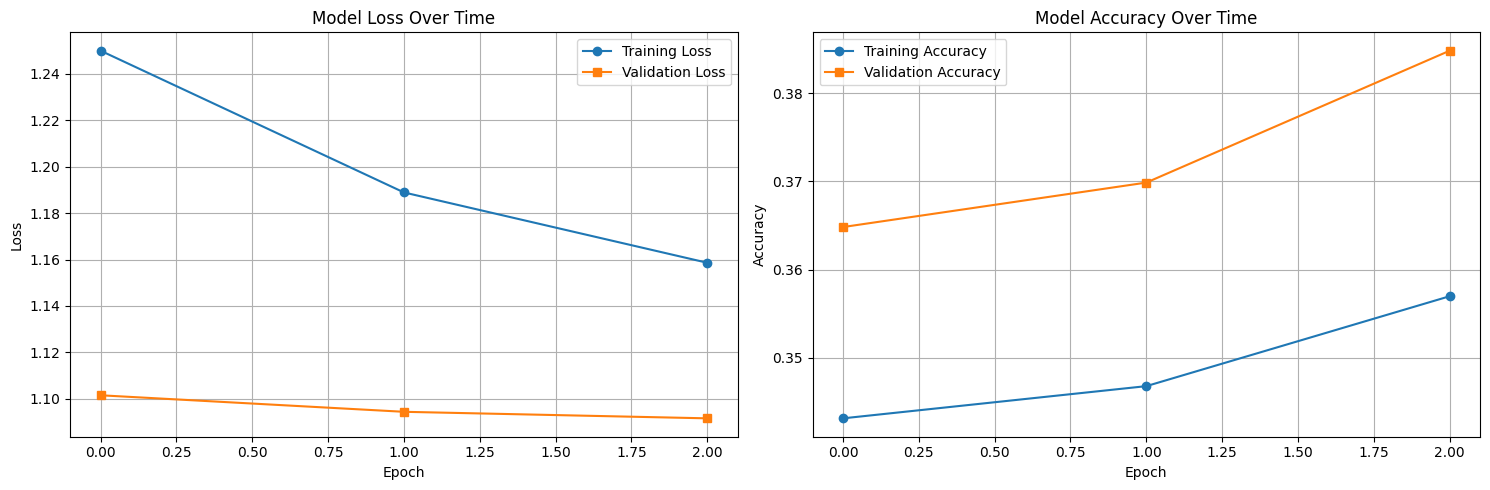


Final Training Loss: 1.1586
Final Validation Loss: 1.0917
Final Training Accuracy: 0.3570
Final Validation Accuracy: 0.3848


In [24]:
# Plot training metrics to understand model performance

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot loss curves
ax1.plot(history.history['loss'], label='Training Loss', marker='o')
ax1.plot(history.history['val_loss'], label='Validation Loss', marker='s')
ax1.set_title('Model Loss Over Time')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

# Plot accuracy curves
ax2.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
ax2.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='s')
ax2.set_title('Model Accuracy Over Time')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

# Print final metrics
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]

print(f"\nFinal Training Loss: {final_train_loss:.4f}")
print(f"Final Validation Loss: {final_val_loss:.4f}")
print(f"Final Training Accuracy: {final_train_acc:.4f}")
print(f"Final Validation Accuracy: {final_val_acc:.4f}")

## Prediction

In [25]:
# Test Set Predictions
print("Preparing test predictions...")

# Clear memory before inference
gc.collect()

# Create test dataset (no labels, no shuffling)
test_ds = build_dataset(
    test_df.options.tolist(), 
    batch_size=CFG.batch_size,
    shuffle=False 
)

# Load the best model weights from training
print("Loading best model weights...")
model.load_weights('best_model.weights.h5')

# Generate predictions
print("Generating predictions...")
final_preds = model.predict(test_ds, verbose=1)

print(f"Predictions shape: {final_preds.shape}")
print(f"Sample predictions (first 5 rows):")
print(final_preds[:5])

Preparing test predictions...
Loading best model weights...
Generating predictions...
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
Predictions shape: (3, 3)
Sample predictions (first 5 rows):
[[0.2366 0.3604 0.403 ]
 [0.3938 0.3618 0.244 ]
 [0.433  0.261  0.3062]]


## Submission

In [26]:
# Create submission dataframe
sub_df = test_df[["id"]].copy()
sub_df[CFG.class_names] = final_preds

# Verify probabilities sum to 1 (sanity check)
prob_sums = sub_df[CFG.class_names].sum(axis=1)
print(f"Probability sums - Min: {prob_sums.min():.6f}, Max: {prob_sums.max():.6f}")

# Save submission file
sub_df.to_csv("submission.csv", index=False)

Probability sums - Min: 1.000000, Max: 1.000000


## Final Analysis & Insights

In [27]:
# Prediction distribution analysis
pred_classes = np.argmax(final_preds, axis=1)
class_dist = pd.Series(pred_classes).map(CFG.label2name).value_counts()

print("\nPredicted class distribution on test set:")
for class_name, count in class_dist.items():
    percentage = (count / len(final_preds)) * 100
    print(f"{class_name}: {count} ({percentage:.1f}%)")



Predicted class distribution on test set:
winner_model_a: 2 (66.7%)
winner_tie: 1 (33.3%)


## Key Takeaways & Potential Improvements

### What Worked Well:
1. **DeBERTa-v3 Architecture**: Excellent for text understanding and comparison
2. **Response Swapping**: Critical for reducing position bias
3. **Memory Optimization**: Mixed precision and gradient accumulation enabled training
4. **Learning Rate Schedule**: Cosine annealing with warmup improved convergence

### Potential Improvements:
1. **Ensemble Methods**: Combine multiple models for better predictions
2. **Advanced Augmentation**: Paraphrasing, backtranslation
3. **Larger Models**: Try DeBERTa-v3 base/large if compute allows
4. **Feature Engineering**: Add response length ratios, readability scores
5. **Cross-Validation**: More robust validation strategy
6. **Post-Processing**: Calibration or threshold optimization